# ML Course 2024 |  Medical Expenses Prediction Challenge

This notebook should serve as a starting point to work on the project. Please read the project description first.

In [1]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2 

# Set team ID
Important: set your Team ID here. You can find it in CMS.

In [410]:
team_id = "18"  # put your team id here

# [Colab only] Connect to your Google Drive

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# %cd "/content/drive/MyDrive/path/to/your/project"

# Imports

[Colab only] Note: if you need to install any packages, run a code cell with content `!pip install packagename`

In [411]:

import os
from itertools import product
from typing import Any

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as skm
from lightgbm import LGBMClassifier  # Change to LGBMClassifier
from prettytable import PrettyTable
from scipy import stats
from scipy.stats import norm, skew  # for some statistics
from sklearn import linear_model, preprocessing
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import (
    SelectKBest,
    VarianceThreshold,
    chi2,
    mutual_info_classif,  # Classification-specific feature selection
)
from sklearn.linear_model import (
    LogisticRegression,  # For classification
)
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    Normalizer,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    quantile_transform,
)
from skopt import BayesSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score  # Import classification metrics
from sklearn.impute import SimpleImputer
# Constants that define the classification and regression targets
CLF_TARGET = "UTILIZATION"
REG_TARGET = "TOT_MED_EXP"

# If using cuML, use GPU-accelerated models
USE_CUML = False  # Set to False for now

if USE_CUML:
    from cuml.common.device_selection import get_global_device_type, set_global_device_type
    from cuml.kernel_ridge import KernelRidge
    from cuml.linear_model import LogisticRegression as cuML_LogisticRegression
    from cuml.svm import SVC

    set_global_device_type("gpu")

    print("cuML's default execution device:", get_global_device_type())
else:
    from sklearn.kernel_ridge import KernelRidge
    from sklearn.svm import SVC

    LogisticRegressionModel = LogisticRegression  # Use sklearn's LogisticRegression

# **Data Analysis & Preprocessing**

## Load Data

In a first step, we load the provided training data from the csv file

In [412]:
df_train = pd.read_csv("data/train.csv")
df_train.drop(columns=[REG_TARGET], inplace=True) # drop the classification target
df_train_mirror = df_train.copy()

print("The loaded dataset has {} rows and {} columns".format(df_train.shape[0], df_train.shape[1]))

The loaded dataset has 15000 rows and 109 columns


In [413]:
df_train.head()

,RACE,SEX,PANEL,WEIGHT,STUDENT_STAT,MIL_ACTIV_DUTY,HON_DISCHARGE,HEALTH_STAT,MENTAL_HLTH,CHRON_BRONCH,...,ADHD_DIAG,NUM_PRESCR_MEDS,DIFFIC_HEAR,DIFFIC_SEE,SMOK,OVR_FEEL_14,MENTAL_HLTH_SCR,PHY_HLTH_SCR,OVR_FEEL_30,UTILIZATION
0,Non-White,1,19,7205.036720,-1,2,2,2,2,2,...,-1,0,2,2,2,1,43.82,61.41,3,LOW
1,White,1,20,5501.113581,-1,4,2,1,1,2,...,-1,12,2,2,2,0,60.12,54.80,0,LOW
2,White,1,20,16797.708379,-1,4,1,3,1,2,...,-1,20,2,2,2,0,60.35,30.08,0,LOW
3,Non-White,2,19,3605.218411,-1,2,2,3,3,2,...,-1,20,2,2,2,0,58.32,50.22,0,LOW
4,Non-White,1,19,11223.127404,1,2,2,1,2,2,...,2,3,2,2,2,0,62.39,56.71,0,LOW


## Data exploration

In [414]:
df_train.describe()

,SEX,PANEL,WEIGHT,STUDENT_STAT,MIL_ACTIV_DUTY,HON_DISCHARGE,HEALTH_STAT,MENTAL_HLTH,CHRON_BRONCH,JNT_PAIN,...,ASTHM_DIAG,ADHD_DIAG,NUM_PRESCR_MEDS,DIFFIC_HEAR,DIFFIC_SEE,SMOK,OVR_FEEL_14,MENTAL_HLTH_SCR,PHY_HLTH_SCR,OVR_FEEL_30
count,15000.000000,15000.00000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.532667,19.53280,9670.900479,-0.658867,2.479533,1.893267,2.378400,2.102067,1.960267,1.636667,...,1.902867,-0.922400,12.024333,1.924800,1.939067,1.244467,0.235533,43.401995,41.278002,2.054600
std,0.498948,0.49894,8555.466893,1.021778,0.867428,0.741830,1.112038,1.064640,0.468369,0.737942,...,0.323273,0.482763,22.539929,0.384822,0.360226,1.723127,1.807173,21.392243,20.943971,4.527846
min,1.000000,19.00000,0.000000,-9.000000,-9.000000,-9.000000,-8.000000,-8.000000,-8.000000,-8.000000,...,-8.000000,-9.000000,0.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,1.000000,19.00000,3956.827352,-1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,...,2.000000,-1.000000,0.000000,2.000000,2.000000,1.000000,0.000000,38.877500,33.510000,0.000000
50%,2.000000,20.00000,7304.928346,-1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,-1.000000,2.000000,2.000000,2.000000,2.000000,0.000000,51.830000,51.240000,1.000000
75%,2.000000,20.00000,12745.004822,-1.000000,2.000000,2.000000,3.000000,3.000000,2.000000,2.000000,...,2.000000,-1.000000,14.000000,2.000000,2.000000,2.000000,0.000000,57.492500,56.150000,3.000000
max,2.000000,20.00000,96471.920237,3.000000,4.000000,4.000000,5.000000,5.000000,2.000000,2.000000,...,2.000000,2.000000,257.000000,2.000000,2.000000,2.000000,6.000000,75.510000,72.070000,24.000000


In [415]:
# Target variable for classification
X = df_train.drop(columns=[CLF_TARGET])
y = df_train[CLF_TARGET]

Text(0.5, 1.0, 'Histogram')

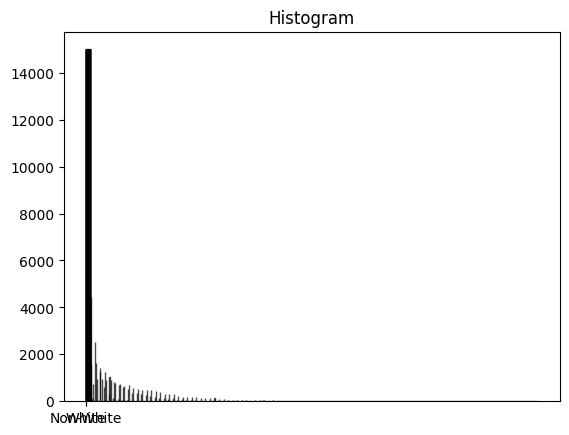

In [416]:
# Check for normalization 
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(X, bins=100, edgecolor='k', alpha=0.7)
plt.title('Histogram')

In [417]:
# Check for missing values
print("Missing values in X:\n", X.isnull().sum())
print("Missing values in y:\n", y.isnull().sum())

Missing values in X:
 RACE               0
SEX                0
PANEL              0
WEIGHT             0
STUDENT_STAT       0
                  ..
SMOK               0
OVR_FEEL_14        0
MENTAL_HLTH_SCR    0
PHY_HLTH_SCR       0
OVR_FEEL_30        0
Length: 108, dtype: int64
Missing values in y:
 0


In [418]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

print(f"Numerical ({len(numerical_cols)}) ", numerical_cols.tolist())
print(f"Categorical ({len(categorical_cols)}): ", categorical_cols.tolist())


Numerical (107)  ['SEX', 'PANEL', 'WEIGHT', 'STUDENT_STAT', 'MIL_ACTIV_DUTY', 'HON_DISCHARGE', 'HEALTH_STAT', 'MENTAL_HLTH', 'CHRON_BRONCH', 'JNT_PAIN', 'PREGNT', 'WALK_LIM', 'ACTIV_LIM', 'SOCIAL_LIM', 'COGNTV_LIM', 'EMPLYMT', 'REGION', 'MARITAL_STAT', 'AGE', 'POVRTY_CAT', 'INSUR_COV', 'TOT_INCOME', 'BM_IDX', 'MULT_HIGHBP', 'HOUSEWRK_LIM', 'SCHOOL_LIM', 'ADV_NO_FAT_FOOD', 'ADV_EXERCISE_MORE', 'ADV_DNTL_CKP', 'FREQ_DNTL_CKP', 'RSN_NO_DNTL_CKP', 'RSN_NO_MED_CKP', 'EMPLYR_INS', 'DOC_CK_BP', 'TAKE_RISK', 'NUM_DEP_OUT_REP_UNT', 'ADV_BOOST_SEAT', 'WHEN_ADV_BOOST_SEAT', 'FEEL_DEPRS', 'ADV_NO_SMKG', 'AGE_DIAG_ADHD', 'CHILD_SUPP', 'PROB_WKIDS', 'PROB_WBHV', 'WEAR_SEATBLT', 'PUB_ASST', 'EDU_DEG', 'SPOUSE_PRSNT', 'TAX_FORM_TYP', 'FOOD_STMP_MNTHS', 'FOOD_STMP_VAL', 'WHEN_ADV_LAP_BLT', 'EDU_YRS', 'WHEN_LST_ASTHMA', 'FAM_INCOME', 'DELAY_PRESCR_MED', 'ADV_LAP_BLT', 'ADV_EAT_HLTHY', 'DOC_TIM_ALN', 'POVRTY_LEV', 'APPT_REG_MEDCARE', 'LOST_ALL_TEETH', 'PROB_BILL_PAY', 'ASPRN_REG', 'OCCUP', 'DIFF_ERRND_AL

In [419]:
# Impute Missing Values
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')
# Separate numerical and categorical data
numerical_data = X[numerical_cols]
categorical_data = X[categorical_cols]

numerical_data_imputed = pd.DataFrame(numerical_imputer.fit_transform(numerical_data), columns=numerical_cols)
categorical_data_imputed = pd.DataFrame(categorical_imputer.fit_transform(categorical_data), columns=categorical_cols)

# Combine Imputed Data
X_imputed = pd.concat([numerical_data_imputed, categorical_data_imputed], axis=1)


In [420]:
# Check missing values after imputation
print("\nMissing values in features after imputation (X_imputed):")
print(X_imputed.isnull().sum())


Missing values in features after imputation (X_imputed):
SEX                0
PANEL              0
WEIGHT             0
STUDENT_STAT       0
MIL_ACTIV_DUTY     0
                  ..
OVR_FEEL_14        0
MENTAL_HLTH_SCR    0
PHY_HLTH_SCR       0
OVR_FEEL_30        0
RACE               0
Length: 108, dtype: int64


In [421]:
# Perform One-Hot Encoding on all categorical columns
X_encoded= pd.get_dummies(X_imputed, drop_first=True)

# Ensure all data is numeric
print(X_encoded.head())

# Check missing values after one-hot encoding
print("\nMissing values in features after one-hot encoding (X_encoded):")
print(X_encoded.isnull().sum())

# Ensure that there are no NaN values in X_encoded
if X_encoded.isnull().sum().sum() != 0:
    raise ValueError("NaN values detected in the encoded feature matrix.")
else:
    print ("NaN values not detected")

   SEX  PANEL        WEIGHT  STUDENT_STAT  MIL_ACTIV_DUTY  HON_DISCHARGE  \
0  1.0   19.0   7205.036720          -1.0             2.0            2.0   
1  1.0   20.0   5501.113581          -1.0             4.0            2.0   
2  1.0   20.0  16797.708379          -1.0             4.0            1.0   
3  2.0   19.0   3605.218411          -1.0             2.0            2.0   
4  1.0   19.0  11223.127404           1.0             2.0            2.0   

   HEALTH_STAT  MENTAL_HLTH  CHRON_BRONCH  JNT_PAIN  ...  ADHD_DIAG  \
0          2.0          2.0           2.0       2.0  ...       -1.0   
1          1.0          1.0           2.0       2.0  ...       -1.0   
2          3.0          1.0           2.0       2.0  ...       -1.0   
3          3.0          3.0           2.0       1.0  ...       -1.0   
4          1.0          2.0           2.0       1.0  ...        2.0   

   NUM_PRESCR_MEDS  DIFFIC_HEAR  DIFFIC_SEE  SMOK  OVR_FEEL_14  \
0              0.0          2.0         2.0   2.0 

In [422]:

# Check Class Distribution
class_distribution = y.value_counts(normalize=True)  # Normalize to get proportions
print("Class distribution in the dataset:")
print(class_distribution)
#imbalanced

Class distribution in the dataset:
UTILIZATION
LOW     0.785867
HIGH    0.214133
Name: proportion, dtype: float64


In [423]:
# Apply Label Encoding to ordinal features
ordinal_mapping = {'LOW': 1, 'HIGH':0}  # Adjust as per your data
y = y.map(ordinal_mapping)


In [424]:
print(y.head())

0    1
1    1
2    1
3    1
4    1
Name: UTILIZATION, dtype: int64


In [154]:
#pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [155]:
'''import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix'''

In [156]:
'''# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print("Original class distribution:")
print(y_train.value_counts())
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())'''

Original class distribution:
UTILIZATION
1    9435
0    2565
Name: count, dtype: int64

Class distribution after SMOTE:
UTILIZATION
1    9435
0    9435
Name: count, dtype: int64


In [232]:
'''from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_model = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(estimator=base_model, n_estimators=50, random_state=42)
ada.fit(X_train, y_train)'''

C:\Users\meenu\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=42)

In [233]:
#y_train_pred = ada.predict(X_train)

In [234]:
#print("Training data metrics:")
#print(confusion_matrix(y_train, y_train_pred))


Training data metrics:
[[1444 1121]
 [ 607 8828]]


In [235]:
#print(classification_report(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       0.70      0.56      0.63      2565
           1       0.89      0.94      0.91      9435

    accuracy                           0.86     12000
   macro avg       0.80      0.75      0.77     12000
weighted avg       0.85      0.86      0.85     12000



In [236]:
'''y_test_pred = ada.predict(X_test)
print("Test data metrics:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))'''

Test data metrics:
[[ 375  272]
 [ 136 2217]]
              precision    recall  f1-score   support

           0       0.73      0.58      0.65       647
           1       0.89      0.94      0.92      2353

    accuracy                           0.86      3000
   macro avg       0.81      0.76      0.78      3000
weighted avg       0.86      0.86      0.86      3000



In [241]:
'''from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
'n_estimators': [50, 100, 200],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 1.0],  # Learning rate
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the best model
y_test_pred_best = best_model.predict(X_test)
print("Test data metrics with best model:")
print(confusion_matrix(y_test, y_test_pred_best))
print(classification_report(y_test, y_test_pred_best))'''

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\meenu\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 200}
Test data metrics with best model:
[[ 349  298]
 [ 108 2245]]
              precision    recall  f1-score   support

           0       0.76      0.54      0.63       647
           1       0.88      0.95      0.92      2353

    accuracy                           0.86      3000
   macro avg       0.82      0.75      0.77      3000
weighted avg       0.86      0.86      0.86      3000



In [84]:
#from sklearn.svm import SVC

#model_svm = SVC(class_weight= 'balanced')  # Increase the weight of Class 1
#model_svm.fit(X_train, y_train)

SVC(class_weight='balanced')

In [85]:
'''datasets = {
    "training data": [X_train, y_train],
    "validation data": [X_test, y_test]
}

# Iterate over the datasets and generate the classification report with macro F1 score
for split_name, dataset in datasets.items():
    X_i, y_i = dataset
    y_pred = model_svm.predict(X_i)
    
    print(f"\nSplit: {split_name}")
    
    # Calculate the classification report with macro averaging
    report = skm.classification_report(y_i, y_pred)
    print(report)
    
    # Additionally, you can also print the macro-averaged F1 score separately
    f1_macro = skm.f1_score(y_i, y_pred, average='macro')
    print(f"Macro-averaged F1 Score for {split_name}: {f1_macro:.4f}")
    '''


Split: training data
              precision    recall  f1-score   support

           0       0.27      0.64      0.38      2565
           1       0.84      0.52      0.64      9435

    accuracy                           0.55     12000
   macro avg       0.55      0.58      0.51     12000
weighted avg       0.72      0.55      0.59     12000

Macro-averaged F1 Score for training data: 0.5100

Split: validation data
              precision    recall  f1-score   support

           0       0.25      0.60      0.35       647
           1       0.82      0.50      0.62      2353

    accuracy                           0.52      3000
   macro avg       0.53      0.55      0.49      3000
weighted avg       0.70      0.52      0.56      3000

Macro-averaged F1 Score for validation data: 0.4855


In [189]:
#from sklearn.linear_model import LogisticRegression

In [190]:
#log_reg = LogisticRegression(solver='liblinear',random_state=0, max_iter=2000).fit(X_train,y_train)

In [191]:
#log_reg.predict(X_train)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [192]:
#log_reg.score(X_train,y_train)

0.8563333333333333

In [193]:
#log_reg.score(X_test,y_test)

0.86

In [194]:
#log_reg1 = LogisticRegression(solver='liblinear',random_state=0,C=0.5,fit_intercept=True, max_iter=2000).fit(X_train,y_train)

In [195]:
#log_reg1.score(X_train,y_train)

0.85625

In [196]:
#log_reg1.score(X_test,y_test)

0.86

In [197]:
#y_predion = log_reg1.predict(X_test)

In [198]:
#y_predion

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [199]:
#from sklearn.metrics import confusion_matrix
#confusion_matrix(y_test,y_predion)

array([[ 335,  312],
       [ 108, 2245]], dtype=int64)

In [95]:
#log_reg1.predict(X_encoded)

TypeError: LinearClassifierMixin.predict() takes 2 positional arguments but 3 were given

In [200]:
'''datasets = {
    "training data": [X_train, y_train],
    "validation data": [X_test, y_test]
}

# Iterate over the datasets and generate the classification report with macro F1 score
for split_name, dataset in datasets.items():
    X_i, y_i = dataset
    y_pred = log_reg1.predict(X_i)
    
    print(f"\nSplit: {split_name}")
    
    # Calculate the classification report with macro averaging
    report = skm.classification_report(y_i, y_pred)
    print(report)
    
    # Additionally, you can also print the macro-averaged F1 score separately
    f1_macro = skm.f1_score(y_i, y_pred, average='macro')
    print(f"Macro-averaged F1 Score for {split_name}: {f1_macro:.4f}")'''


Split: training data
              precision    recall  f1-score   support

           0       0.74      0.50      0.60      2565
           1       0.88      0.95      0.91      9435

    accuracy                           0.86     12000
   macro avg       0.81      0.73      0.76     12000
weighted avg       0.85      0.86      0.85     12000

Macro-averaged F1 Score for training data: 0.7553

Split: validation data
              precision    recall  f1-score   support

           0       0.76      0.52      0.61       647
           1       0.88      0.95      0.91      2353

    accuracy                           0.86      3000
   macro avg       0.82      0.74      0.76      3000
weighted avg       0.85      0.86      0.85      3000

Macro-averaged F1 Score for validation data: 0.7646


In [1]:
'''# Run this to save a file with your predictions on the test set to be submitted

split = "test_public"  # replace by 'test_private' for FINAL submission

df_test = pd.read_csv(f"data/{split}.csv")
# Separate the features (X) from the test data
X_test = df_test.copy()

# Identify categorical and numerical columns
categorical_cols_test = X_test.select_dtypes(include=['object', 'category']).columns
numerical_cols_test = X_test.select_dtypes(include=['number']).columns

# Impute Missing Values using the same strategies as the training data
numerical_imputer_test = SimpleImputer(strategy='mean')
categorical_imputer_test = SimpleImputer(strategy='most_frequent')

numerical_data_test = X_test[numerical_cols_test]
categorical_data_test = X_test[categorical_cols_test]

numerical_data_imputed_test = pd.DataFrame(numerical_imputer_test.fit_transform(numerical_data_test), columns=numerical_cols_test)
categorical_data_imputed_test = pd.DataFrame(categorical_imputer_test.fit_transform(categorical_data_test), columns=categorical_cols_test)

# Combine Imputed Data
X_imputed_test = pd.concat([numerical_data_imputed_test, categorical_data_imputed_test], axis=1)

# Perform One-Hot Encoding on all categorical columns
X_encoded_test = pd.get_dummies(X_imputed_test, drop_first=True)

# Step 3: Feature Selection and Transformation

# Align the test data with the training data to ensure the same features
#X_encoded_test = X_encoded_test.reindex(columns=X_selected_df.columns, fill_value=0)

# Step 4: Make predictions using the trained model
y_hat = log_reg1.predict(X_encoded_test)

print("Predicted")'''

NameError: name 'pd' is not defined

### *Variance Threshold Analysis*

In [425]:
selector = VarianceThreshold(threshold=0.01)  # Adjusted threshold for variance
X_reduced = selector.fit_transform(X_encoded)
print(f"Reduced feature set shape: {X_reduced.shape}")



Reduced feature set shape: (15000, 106)


In [194]:
'''from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

for threshold in thresholds:
    selector = VarianceThreshold(threshold=threshold)
    X_reduced = selector.fit_transform(X_encoded)
    
    # Train and evaluate a model
    model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
    scores = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
    print(f"Threshold: {threshold}, Mean CV Accuracy: {scores.mean()}")'''

Threshold: 0.01, Mean CV Accuracy: 0.8506666666666666
Threshold: 0.05, Mean CV Accuracy: 0.8502666666666666
Threshold: 0.1, Mean CV Accuracy: 0.8502000000000001
Threshold: 0.2, Mean CV Accuracy: 0.8497333333333333


In [426]:
# Convert back to DataFrame to handle skewness
# Get the columns that were retained after variance thresholding
reduced_columns = X_encoded.columns[selector.get_support()]
X_reduced_df = pd.DataFrame(X_reduced, columns=reduced_columns)

### *Skewness Analysis*

In [427]:
# Skewness Analysis
skewness = X_reduced_df.apply(lambda x: skew(x.dropna()))  # Compute skewness
skewed_features = skewness[skewness > 0.5].index  # Select features with skewness > 0.5

print(f"Skewed features before transformation: {len(skewed_features)}")
print(skewness[skewed_features])


Skewed features before transformation: 43
WEIGHT                    2.445741
STUDENT_STAT              2.796993
MIL_ACTIV_DUTY            0.855157
PREGNT                    1.117256
MARITAL_STAT              0.506803
INSUR_COV                 0.926003
TOT_INCOME                2.564671
BM_IDX                    2.221857
RSN_NO_DNTL_CKP          16.338814
RSN_NO_MED_CKP           15.880579
NUM_DEP_OUT_REP_UNT       5.291484
AGE_DIAG_ADHD            21.932072
CHILD_SUPP               13.979793
PROB_WKIDS              115.510764
PROB_WBHV               114.325716
PUB_ASST                 13.513661
TAX_FORM_TYP              9.159786
FOOD_STMP_MNTHS           2.011646
FOOD_STMP_VAL             7.813558
WHEN_ADV_LAP_BLT         19.115694
WHEN_LST_ASTHMA           5.565270
FAM_INCOME                2.082456
ADV_LAP_BLT               1.958450
ADV_EAT_HLTHY             2.015631
DOC_TIM_ALN               2.211253
POVRTY_LEV                2.179222
OCCUP                     0.675369
DIAB_KIDNY   

In [429]:

# Define the function to further reduce skewness
def further_reduce_skewness(df, skewness_threshold=0.5):
    # Copy the DataFrame to avoid modifying the original
    df_transformed = df.copy()
    
    for feature in df_transformed.columns:
        if skew(df_transformed[feature].dropna()) > skewness_threshold:
            if df_transformed[feature].min() <= 0:
                # Apply Box-Cox transformation if there are non-positive values
                df_transformed[feature], _ = stats.boxcox(df_transformed[feature] + 1 - df_transformed[feature].min())
            else:
                # Apply log transformation
                df_transformed[feature] = np.log1p(df_transformed[feature])
                
                # Optionally apply square root transformation if log transformation isn't enough
                if skew(df_transformed[feature].dropna()) > skewness_threshold:
                    df_transformed[feature] = np.sqrt(df_transformed[feature])
    
    return df_transformed

# Apply the function to further reduce skewness
X_reduced_further_transformed = further_reduce_skewness(X_reduced_df)

# Recalculate skewness after additional transformations
skewness_further_transformed = X_reduced_further_transformed.apply(lambda x: skew(x.dropna()))

# Print skewness of features after transformation
print(f"Skewed features after further transformation:")
print(skewness_further_transformed[skewness_further_transformed > 0.5])


Skewed features after further transformation:
INSUR_COV                0.648572
RSN_NO_MED_CKP           6.084870
NUM_DEP_OUT_REP_UNT      1.592804
CHILD_SUPP               6.315143
PUB_ASST                 9.952422
WHEN_ADV_LAP_BLT        16.423488
WHEN_LST_ASTHMA          1.932275
ADV_LAP_BLT              3.306582
ADV_EAT_HLTHY            3.405320
DOC_TIM_ALN              3.246564
DIAB_KIDNY               0.982533
DIAB_INSLN               0.945097
DIAB_MED                 1.083630
DISPSN_STAT              7.254502
DAYS_CAREOTHR_NOWORK     1.061184
WHEN_ADV_EXERCISE       15.850591
DEAF                     4.273859
BLIND                    5.182255
NON_ENG_LANG             0.573252
ADHD_DIAG                1.059323
dtype: float64


In [430]:
# Feature Selection
select_k_best = SelectKBest(mutual_info_classif, k=35)
X_selected = select_k_best.fit_transform(X_reduced_further_transformed, y)
X_selected_df = pd.DataFrame(X_selected, columns=select_k_best.get_feature_names_out())
print(f"Selected feature set shape: {X_selected.shape}")
print(X_selected_df)

Selected feature set shape: (15000, 35)
       MIL_ACTIV_DUTY  HEALTH_STAT  JNT_PAIN  WALK_LIM  ACTIV_LIM  SOCIAL_LIM  \
0            6.210471          2.0       2.0       2.0        2.0         2.0   
1            7.028482          1.0       2.0       2.0        2.0         2.0   
2            7.028482          3.0       2.0       2.0        2.0         2.0   
3            6.210471          3.0       1.0       2.0        2.0         2.0   
4            6.210471          1.0       1.0       2.0        2.0         2.0   
...               ...          ...       ...       ...        ...         ...   
14995        6.210471          2.0       2.0       2.0        2.0         2.0   
14996        6.210471          4.0       2.0       2.0        2.0         2.0   
14997        6.210471          2.0       2.0       2.0        2.0         2.0   
14998        6.210471          3.0       1.0       2.0        2.0         2.0   
14999        6.210471          2.0       2.0       2.0        2.0    

In [431]:
#Outliers detection
from sklearn.neighbors import LocalOutlierFactor

# Define parameter grid
lof = LocalOutlierFactor(n_neighbors= 100,contamination= 0.15) # with n_neighbors = 100, contamination = 0.05 the classification score got improved to 0.7495
y_pred = lof.fit_predict(X_selected_df)

# Detect outliers (True means outlier, False means inlier)
outliers = y_pred == -1

In [432]:
num_outliers = np.sum(outliers)
print(f"Number of detected outliers: {num_outliers}")

Number of detected outliers: 2250


In [433]:
outlier_data = X_selected_df[outliers]
print(outlier_data)

       MIL_ACTIV_DUTY  HEALTH_STAT  JNT_PAIN  WALK_LIM  ACTIV_LIM  SOCIAL_LIM  \
9            6.210471          3.0       2.0       2.0        2.0         2.0   
15           6.210471          2.0       2.0       2.0        2.0         2.0   
17           7.028482          3.0       1.0       1.0        1.0         1.0   
18           6.210471          4.0       1.0       2.0        1.0         2.0   
22           7.028482          2.0       2.0       2.0       -8.0         2.0   
...               ...          ...       ...       ...        ...         ...   
14978        6.210471          1.0       2.0       2.0        2.0         2.0   
14984        6.210471          1.0       2.0       2.0        2.0         2.0   
14985        6.210471          2.0       2.0       2.0        2.0         2.0   
14986        7.028482          2.0       1.0       2.0        2.0         2.0   
14996        6.210471          4.0       2.0       2.0        2.0         2.0   

       COGNTV_LIM  EMPLYMT 

In [434]:
# Remove outliers from dataset
X_no_outliers = X_selected_df[~outliers]
y_no_outliers = y[~outliers]


In [435]:
print(X_no_outliers)

       MIL_ACTIV_DUTY  HEALTH_STAT  JNT_PAIN  WALK_LIM  ACTIV_LIM  SOCIAL_LIM  \
0            6.210471          2.0       2.0       2.0        2.0         2.0   
1            7.028482          1.0       2.0       2.0        2.0         2.0   
2            7.028482          3.0       2.0       2.0        2.0         2.0   
3            6.210471          3.0       1.0       2.0        2.0         2.0   
4            6.210471          1.0       1.0       2.0        2.0         2.0   
...               ...          ...       ...       ...        ...         ...   
14994        6.210471          2.0       2.0       2.0        2.0         2.0   
14995        6.210471          2.0       2.0       2.0        2.0         2.0   
14997        6.210471          2.0       2.0       2.0        2.0         2.0   
14998        6.210471          3.0       1.0       2.0        2.0         2.0   
14999        6.210471          2.0       2.0       2.0        2.0         2.0   

       COGNTV_LIM  EMPLYMT 

### *Correlation Analysis*


Found 6 columns with correlation >= 0.9
['HOUSEWRK_LIM', 'SCHOOL_LIM', 'OCCUP', 'UNION_STAT', 'HIGH_BP_DIAG', 'ARTHR_TYPE']


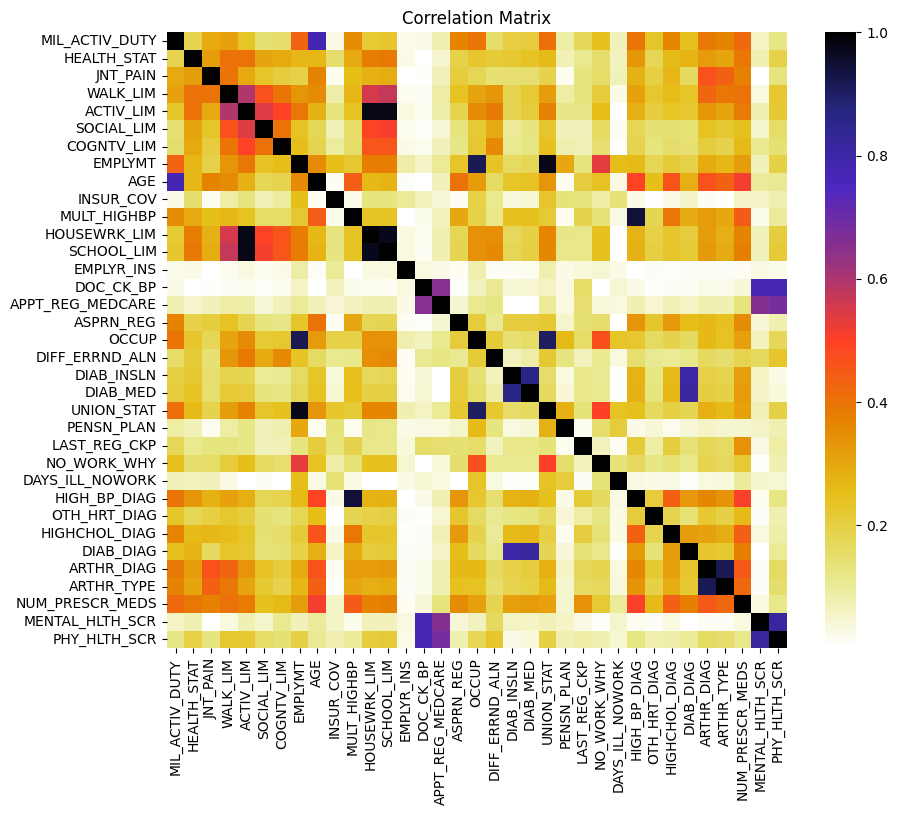

Number of columns after dropping correlated columns: 29


In [436]:
# Correlation Analysis
CORRELATION_THRESHOLD = 0.9  # Define the correlation threshold
def find_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    correlated_features = [column for column in upper.columns if any(upper[column] > threshold)]
    return correlated_features, corr_matrix

correlated_cols, corr_matrix = find_correlated_features(X_no_outliers)
print(f"\nFound {len(correlated_cols)} columns with correlation >= {CORRELATION_THRESHOLD}")
print(correlated_cols)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap=plt.cm.CMRmap_r)
plt.title("Correlation Matrix")
plt.show()

# Drop Highly Correlated Features
X_no_outliers = X_no_outliers.drop(columns=correlated_cols)
print(f"Number of columns after dropping correlated columns: {X_no_outliers.shape[1]}")


In [437]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)


In [438]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [439]:
# Print the first few rows of the scaled data
print("\nScaled features")
print(X_train_scaled)


Scaled features
[[-0.56532261  0.57698786  0.7026321  ... -1.11400519  0.62677057
   0.55439081]
 [ 1.75775734 -0.36285184 -1.3693099  ...  0.3785341   0.28609966
  -0.66902173]
 [-0.56532261 -1.30269153  0.7026321  ... -1.11400519 -2.29548445
  -2.21711696]
 ...
 [ 1.75775734  0.57698786 -1.3693099  ... -0.12046995  0.73348073
   0.22512795]
 [-0.56532261 -0.36285184  0.7026321  ...  0.3785341  -0.50746316
   0.38950493]
 [-0.56532261 -1.30269153 -1.3693099  ...  0.09728109  0.67887318
   0.55540863]]


In [440]:
print(X_test_scaled)

[[-0.56532261  0.57698786  0.7026321  ... -0.45550709 -0.26448464
   0.76100707]
 [ 1.75775734  0.57698786 -1.3693099  ...  1.41892671  0.02959451
   0.41189684]
 [-0.56532261 -1.30269153  0.7026321  ...  0.7974321  -0.23492643
   1.03632578]
 ...
 [-0.56532261 -1.30269153  0.7026321  ... -0.12046995 -2.29548445
  -2.21711696]
 [-0.56532261 -1.30269153  0.7026321  ...  0.9818227   0.41936211
   0.44141345]
 [ 1.75775734  0.57698786  0.7026321  ... -0.45550709  0.70492449
   0.30706199]]


# Linear classification

In this part, we will train a simple linear classification model to predict our target `UTILIZATION`.


We will first change our targets (classes: LOW, HIGH) to numeric targets. Then, we solve a logistic regression problem by minimizing the binary cross-entropy function

$$
J(\theta) = -\frac{1}{n} \sum_{i=1}^{n} \left( y_i \log(p_{\theta}(\hat{y}=1 | \mathbf{x}_i)) + (1 - y_i) \log(p_{\theta}(\hat{y}=0 | \mathbf{x}_i)) \right)
$$

where $y_i \in \{0, 1\}$ and $p_{\theta}(\hat{y}=k | \mathbf{x}_i)$ is the probability assigned by our model to class $k$ having observed features $\mathbf{x}_i$.

0 refers to HIGH, and 1 refers to LOW

### Process the data

In [441]:
# Define separate grids for different solvers
param_grid = [
    {
        'penalty': ['l2'],  # lbfgs supports only l2 penalty
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'saga'],  # lbfgs and saga support l2
        'class_weight': ['balanced'],
        'max_iter': [100, 500, 1000, 1500],
    },
    {
        'penalty': ['l1'],  # saga and liblinear support l1 penalty
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],  # saga and liblinear support l1
        'class_weight': ['balanced'],
        'max_iter': [100, 500, 1000, 1500],
    }
]


In [442]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [443]:
# Initialize GridSearchCV with the updated param_grid
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=stratified_kfold,
    verbose=3,
    n_jobs=-1
)


### Fit the model by using training data

In [444]:
grid_search.fit(X_train_scaled, y_train)
best_clf = grid_search.best_estimator_
# Print the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score: 0.7370


Now evaluate your model. Check the appendix for details on micro, macro and weighted averaging

In [445]:
# Define your datasets
datasets = {
    "training data": [X_train_scaled, y_train],
    "validation data": [X_test_scaled, y_test]
}

# Iterate over the datasets and generate the classification report with macro F1 score
for split_name, dataset in datasets.items():
    X_i, y_i = dataset
    y_pred = best_clf.predict(X_i)
    
    print(f"\nSplit: {split_name}")
    
    # Calculate the classification report with macro averaging
    report = skm.classification_report(y_i, y_pred)
    print(report)
    
    # Additionally, you can also print the macro-averaged F1 score separately
    f1_macro = skm.f1_score(y_i, y_pred, average='macro')
    print(f"Macro-averaged F1 Score for {split_name}: {f1_macro:.4f}")


Split: training data
              precision    recall  f1-score   support

           0       0.51      0.79      0.62      2236
           1       0.93      0.79      0.85      7964

    accuracy                           0.79     10200
   macro avg       0.72      0.79      0.74     10200
weighted avg       0.84      0.79      0.80     10200

Macro-averaged F1 Score for training data: 0.7369

Split: validation data
              precision    recall  f1-score   support

           0       0.52      0.82      0.64       563
           1       0.94      0.79      0.86      1987

    accuracy                           0.79      2550
   macro avg       0.73      0.80      0.75      2550
weighted avg       0.85      0.79      0.81      2550

Macro-averaged F1 Score for validation data: 0.7473


At this point, we can use our model to predict healthcare utilization on the test set.

We again need to follow a specific namim format when saving the predictions. Similarly to before, the name of the file should be `<TEAM_ID>__<SPLIT>__clf_pred.npy`.



In [446]:
# Run this to save a file with your predictions on the test set to be submitted

split = "test_public"  # replace by 'test_private' for FINAL submission

df_test = pd.read_csv(f"data/{split}.csv")
# Separate the features (X) from the test data
X_test = df_test.copy()

# Identify categorical and numerical columns
categorical_cols_test = X_test.select_dtypes(include=['object', 'category']).columns
numerical_cols_test = X_test.select_dtypes(include=['number']).columns

# Impute Missing Values using the same strategies as the training data
numerical_imputer_test = SimpleImputer(strategy='mean')
categorical_imputer_test = SimpleImputer(strategy='most_frequent')

numerical_data_test = X_test[numerical_cols_test]
categorical_data_test = X_test[categorical_cols_test]

numerical_data_imputed_test = pd.DataFrame(numerical_imputer_test.fit_transform(numerical_data_test), columns=numerical_cols_test)
categorical_data_imputed_test = pd.DataFrame(categorical_imputer_test.fit_transform(categorical_data_test), columns=categorical_cols_test)

# Combine Imputed Data
X_imputed_test = pd.concat([numerical_data_imputed_test, categorical_data_imputed_test], axis=1)

# Perform One-Hot Encoding on all categorical columns
X_encoded_test = pd.get_dummies(X_imputed_test, drop_first=True)

# Step 3: Feature Selection and Transformation

# Align the test data with the training data to ensure the same features
X_encoded_test = X_encoded_test.reindex(columns=X_no_outliers.columns, fill_value=0)

scaler = StandardScaler()
X_test_set_scaled = scaler.fit_transform(X_encoded_test)

# Step 4: Make predictions using the trained model
y_hat = best_clf.predict(X_test_set_scaled)

print("Predicted")

Predicted


In [447]:
team_id ='18'

folder = "./results"
np.save(os.path.join(folder, f"{team_id}__{split}__clf_pred.npy"), y_hat)

# Submission to CMS

Put your .npy files for both regression and classification tasks in the same zip file. Please name the file as `<TEAM_ID>.zip` (e.g. `123.zip`) and upload it to CMS system. It is essential that the files inside the .zip are named as follow:

`<TEAM_ID>__<SPLIT>__reg_pred.npy` \
`<TEAM_ID>__<SPLIT>__clf_pred.npy`

Above, `<SPLIT>` should correspond to `test_public` for the leaderboard and `test_private` for the final submission.
As long as the `test_private.csv` data file is not released yet, the zip will contain only two files.


### Appendix: Reminders about macro and micro averaging:

When evaluating a classification model using `skm.classification_report(y_i, y_pred)` as done above, we get a macro and a weighted average.

In the context of computing F1-score, "macro" and "micro" averaging are two commonly used techniques to aggregate the per-class F1-scores.

**Micro-average**: Compute the F1-score globally by counting the total true positives, false negatives, and false positives over all classes, and then calculating precision, recall, and F1-score using these aggregated values.

**Macro-average**: Calculate the F1-score for each class separately, and then take the average of these per-class F1-scores.

The main difference between these two techniques is the way they treat class imbalance. Micro-average treats all classes equally, regardless of their size, while macro-average treats each class equally, regardless of the number of samples in that class.

Micro-average is often used when we care about overall performance across all classes, and we want to give more weight to the performance on larger classes. In contrast, macro-average is often used when we want to evaluate the performance on each class separately and give equal weight to each class.


In addition to micro and macro averaging, there is another common technique for computing the F1-score called **weighted averaging**.

**Weighted averaging** is similar to macro averaging in that it computes the per-class F1-score and then takes the average of these scores. However, unlike macro averaging, weighted averaging takes into account the number of samples in each class when computing the average. Specifically, the weighted average is computed as follows:

- Compute the F1-score for each class separately.
- Compute the weight for each class as the number of samples in that class divided by the total number of samples.
- Compute the weighted average of the per-class F1-scores, where each per-class F1-score is weighted by the weight of that class.

The weighted average is commonly used when the dataset is imbalanced, meaning that some classes have many more samples than others. In such cases, using the simple average (macro-average) would give too much weight to the smaller classes, while using micro-average would give too much weight to the larger classes. The weighted average strikes a balance between these two approaches by giving more weight to the classes with more samples while still taking into account the performance of all classes.


When computing the F1 score for the leaderboard and the final challenge results, we will be using the macro averaging strategy.